Para conseguir lidar com a analise de sentimentos no rosto humano será necessário utilizar a biblioteca TensorFlow com o ImageDataGenerator

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Para conseguirmos lidar com nosso dataset teremos que definir os caminhos dele

In [50]:
dir_train = "../data/Fer2013Dataset/test"
dir_test = "../data/Fer2013Dataset/train"

Agora precisamos criar varaiveis que vão conter transformções que queremos aplicar em nossos datasets.

In [51]:
datagen_train = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    validation_split = 0.2
)

datagen_test = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

Agora iremos carregar o caminho das imagens para poder preparar elas para treinamento em um modelo

In [52]:
train_generator = datagen_train.flow_from_directory(
    directory = dir_train,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "training"
)

validation_generator = datagen_train.flow_from_directory(
    directory = dir_test,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation"
)

Found 5746 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


Verificcando nossa base

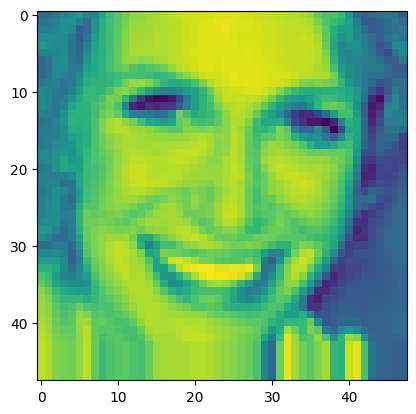

In [53]:
import matplotlib.pyplot as plt

for images, _ in train_generator:
    plt.imshow(images[0])
    plt.show()
    break

# Criando uma CNN para nossa aplicação
Agora que já cuidamos do preprocessamento das nossa imagens, podemos utilizá-las para treinar um modelo CNN. O que iremos utilizar será o mini_XCEPTION

In [54]:
input_shape = (48, 48, 1)
num_classes = 7
l2_regularization = 0.01
patience = 100

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, SeparableConv2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras import layers

In [ ]:
regularization = l2(l2_regularization)

Primeiro aplicamos um entrada com o numero de pixels (48,48) e a escala (1), grayscale.

In [ ]:
img_input = Input(input_shape)

Temos nossa primeira camada convolucional para nosso modelo

A bias é False, pois aplicamos a normalização na linha seguinte `BatchNormalization`.

In [ ]:
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
            use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

Depois fazemos um loop de bloco para cada camada posterior. Está em loop, pois serão o mesmo bloco de comando e somente o valor do filtro mudará

In [57]:
filter_list = [16, 32, 64, 128]
for n in filter_list:
    residual = Conv2D(n, (1, 1), strides=(2, 2),
                        padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(n, (3, 3), padding='same',
                    depthwise_regularizer=regularization,
                    pointwise_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])



No fim, salvamos nosso modelo criado numa variável

In [58]:
x = Conv2D(num_classes, (3, 3),
            # kernel_regularizer=regularization,
            padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax', name='predictions')(x)

model = Model(img_input, output)

Resumo da arquitetura de rede feita para nosso modelo

In [ ]:
model.summary()

Compilando o modelo

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 46, 46, 8) │         72 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46, 8) │         32 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 46, 46, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 44, 44, 8) │        576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44, 8) │         32 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 44, 44, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 44, 44,    │        200 │ activation_9[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_13 │ (None, 44, 44,    │        400 │ activation_10[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 22, 22,    │        128 │ activation_9[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │         64 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 22, 22,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 22, 22,    │        656 │ add_4[0][0]       │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)

Agora iremos trainar nosso modelo com base nos preprocessamentos feitos

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,   
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "melhor_modelo.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint]
)


c:\Users\gmara\Documents\Sourcetree\PhobiaScan\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.2247 - loss: 5.7896
Epoch 1: val_accuracy improved from -inf to 0.25152, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 998ms/step - accuracy: 0.2249 - loss: 5.7842 - val_accuracy: 0.2515 - val_loss: 4.6182
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2774 - loss: 4.1981
Epoch 2: val_accuracy did not improve from 0.25152
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.2773 - loss: 4.1954 - val_accuracy: 0.2513 - val_loss: 3.5898
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2804 - loss: 3.3310
Epoch 3: val_accuracy did not improve from 0.25152
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.2805 - loss: 3.3293 - val_accuracy: 0.2513 - val_loss: 2.9973
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3208 - loss: 2.7556
Epoch 4: val_accuracy did not improve from 0.25152
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.3209 - loss: 2.7547 - val_accuracy: 0.2513 - val_loss: 2.7499
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3354 - loss: 2.4412
Epoch 5: val_accuracy improved 

90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.3356 - loss: 2.4404 - val_accuracy: 0.2564 - val_loss: 2.5039
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3619 - loss: 2.2038
Epoch 6: val_accuracy did not improve from 0.25640
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.3620 - loss: 2.2032 - val_accuracy: 0.2369 - val_loss: 2.3624
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3969 - loss: 2.0105
Epoch 7: val_accuracy improved from 0.25640 to 0.25971, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.3970 - loss: 2.0102 - val_accuracy: 0.2597 - val_loss: 2.4652
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3814 - loss: 1.9466
Epoch 8: val_accuracy did not improve from 0.25971
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.3817 - loss: 1.9461 - val_accuracy: 0.2406 - val_loss: 2.1319
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4255 - loss: 1.8473
Epoch 9: val_accuracy improved from 0.25971 to 0.35168, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4255 - loss: 1.8471 - val_accuracy: 0.3517 - val_loss: 1.9626
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4337 - loss: 1.7683
Epoch 10: val_accuracy did not improve from 0.35168
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4337 - loss: 1.7682 - val_accuracy: 0.3024 - val_loss: 2.1150
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4521 - loss: 1.7102
Epoch 11: val_accuracy did not improve from 0.35168
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4520 - loss: 1.7102 - val_accuracy: 0.3372 - val_loss: 2.0339
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4465 - loss: 1.6830
Epoch 12: val_accuracy did not improve from 0.35168
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4464 - loss: 1.6831 - val_accuracy: 0.3303 - val_loss: 2.1209
Epoch 13/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4598 - loss: 1.6447
Epoch 13: val_accuracy i

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4597 - loss: 1.6448 - val_accuracy: 0.3611 - val_loss: 2.0657
Epoch 14/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4565 - loss: 1.6265
Epoch 14: val_accuracy did not improve from 0.36109
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.4564 - loss: 1.6265 - val_accuracy: 0.3597 - val_loss: 1.8823
Epoch 15/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4604 - loss: 1.6113
Epoch 15: val_accuracy improved from 0.36109 to 0.37885, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4605 - loss: 1.6113 - val_accuracy: 0.3789 - val_loss: 1.8299
Epoch 16/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4856 - loss: 1.5638
Epoch 16: val_accuracy did not improve from 0.37885
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4855 - loss: 1.5639 - val_accuracy: 0.3557 - val_loss: 1.8693
Epoch 17/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4766 - loss: 1.5610
Epoch 17: val_accuracy improved from 0.37885 to 0.44034, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4766 - loss: 1.5611 - val_accuracy: 0.4403 - val_loss: 1.6766
Epoch 18/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4788 - loss: 1.5347
Epoch 18: val_accuracy did not improve from 0.44034
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.4788 - loss: 1.5349 - val_accuracy: 0.4208 - val_loss: 1.7881
Epoch 19/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4866 - loss: 1.5287
Epoch 19: val_accuracy did not improve from 0.44034
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.4866 - loss: 1.5288 - val_accuracy: 0.4290 - val_loss: 1.6569
Epoch 20/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4959 - loss: 1.5093
Epoch 20: val_accuracy improved from 0.44034 to 0.45132, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.4959 - loss: 1.5093 - val_accuracy: 0.4513 - val_loss: 1.6314
Epoch 21/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5000 - loss: 1.4730
Epoch 21: val_accuracy did not improve from 0.45132
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.4999 - loss: 1.4733 - val_accuracy: 0.4025 - val_loss: 1.7526
Epoch 22/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4923 - loss: 1.5029
Epoch 22: val_accuracy improved from 0.45132 to 0.47291, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.4924 - loss: 1.5028 - val_accuracy: 0.4729 - val_loss: 1.5854
Epoch 23/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5065 - loss: 1.4823
Epoch 23: val_accuracy did not improve from 0.47291
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5065 - loss: 1.4822 - val_accuracy: 0.4374 - val_loss: 1.6609
Epoch 24/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5022 - loss: 1.4751
Epoch 24: val_accuracy did not improve from 0.47291
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5022 - loss: 1.4751 - val_accuracy: 0.4076 - val_loss: 1.9079
Epoch 25/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5292 - loss: 1.4282
Epoch 25: val_accuracy improved from 0.47291 to 0.48075, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5290 - loss: 1.4285 - val_accuracy: 0.4808 - val_loss: 1.5277
Epoch 26/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5168 - loss: 1.4326
Epoch 26: val_accuracy did not improve from 0.48075
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5167 - loss: 1.4328 - val_accuracy: 0.4407 - val_loss: 1.7622
Epoch 27/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5257 - loss: 1.4223
Epoch 27: val_accuracy did not improve from 0.48075
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5256 - loss: 1.4224 - val_accuracy: 0.4592 - val_loss: 1.5987
Epoch 28/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5214 - loss: 1.4258
Epoch 28: val_accuracy did not improve from 0.48075
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.5214 - loss: 1.4259 - val_accuracy: 0.4543 - val_loss: 1.6068
Epoch 29/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5180 - loss: 1.4407
Epoch 29: val_accuracy d

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5211 - loss: 1.4118 - val_accuracy: 0.4828 - val_loss: 1.5260
Epoch 32/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5304 - loss: 1.4015
Epoch 32: val_accuracy did not improve from 0.48284
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5303 - loss: 1.4017 - val_accuracy: 0.3973 - val_loss: 1.6525
Epoch 33/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5290 - loss: 1.3916
Epoch 33: val_accuracy did not improve from 0.48284
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5290 - loss: 1.3917 - val_accuracy: 0.4760 - val_loss: 1.5196
Epoch 34/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5374 - loss: 1.3968
Epoch 34: val_accuracy did not improve from 0.48284
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5372 - loss: 1.3968 - val_accuracy: 0.4558 - val_loss: 1.5445
Epoch 35/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5384 - loss: 1.3804
Epoch 35: val_accuracy i

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5384 - loss: 1.3804 - val_accuracy: 0.4917 - val_loss: 1.5495
Epoch 36/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5334 - loss: 1.3571
Epoch 36: val_accuracy did not improve from 0.49173
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5333 - loss: 1.3573 - val_accuracy: 0.4719 - val_loss: 1.5510
Epoch 37/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5470 - loss: 1.3582
Epoch 37: val_accuracy did not improve from 0.49173
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5468 - loss: 1.3585 - val_accuracy: 0.4794 - val_loss: 1.5394
Epoch 38/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5300 - loss: 1.3828
Epoch 38: val_accuracy did not improve from 0.49173
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5300 - loss: 1.3827 - val_accuracy: 0.4410 - val_loss: 1.7176
Epoch 39/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5354 - loss: 1.3661
Epoch 39: val_accuracy d

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5443 - loss: 1.3532 - val_accuracy: 0.4994 - val_loss: 1.5062
Epoch 49/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5547 - loss: 1.3007
Epoch 49: val_accuracy improved from 0.49939 to 0.51019, saving model to melhor_modelo.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5546 - loss: 1.3010 - val_accuracy: 0.5102 - val_loss: 1.4392
Epoch 50/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5439 - loss: 1.3200
Epoch 50: val_accuracy did not improve from 0.51019
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5440 - loss: 1.3200 - val_accuracy: 0.3877 - val_loss: 1.8479


Plotamos o gráfico de perda durante o treinamento

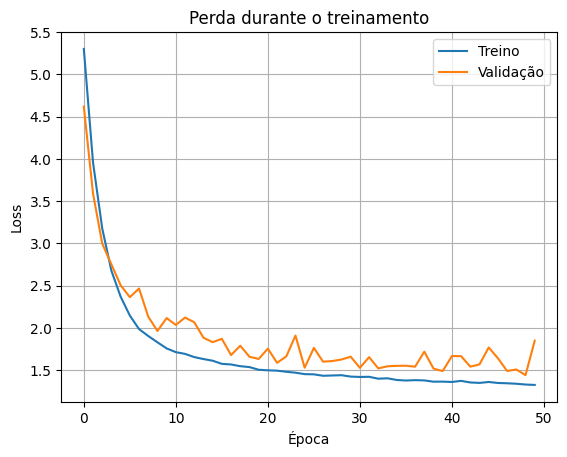

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Plotamos o gráfico de acurácia durante o treinamento

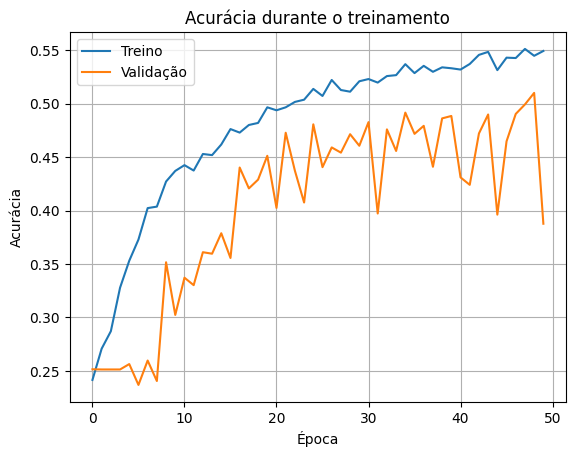

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


Salvamos nosso modelo

In [68]:
model.save("modelo_emocoes.keras")


Dessa forma, podemos agora sempre carregar nosso modelo para testar

In [3]:
from keras.models import load_model
model = load_model("modelo_emocoes.keras")


c:\Users\gmara\Documents\Sourcetree\PhobiaScan\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 54 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Teste

Agora, podemos realizar testes para verificar se nosso modelo está reconhcendo ou não

(225, 161, 3)

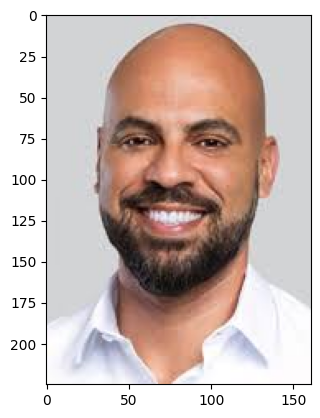

In [4]:
import matplotlib.pyplot as plt
my_image = plt.imread("../data/test/tes.jfif")
plt.imshow(my_image)
my_image.shape

Aplicamos transformações de tamanho para ficar no nosso padrão (48,48)

array([[[0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        ...,
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412]],

       [[0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        ...,
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412]],

       [[0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        ...,
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412],
        [0.82352941, 0.82745098, 0.83529412]],

       ...,

       [[0.98496428, 0.98239885, 0.99568182],
        [0.97290565, 0.96943437, 0.98909308],
        [0.95286815, 0

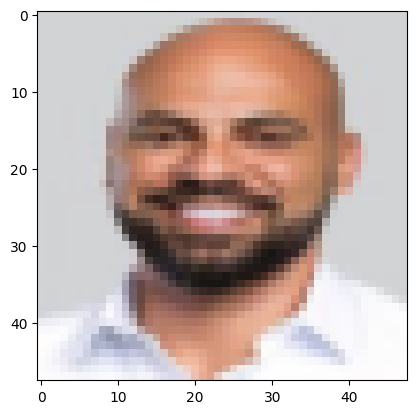

In [5]:
from skimage.transform import resize
my_image_resized = resize(my_image, (48,48,3))

img = plt.imshow(my_image_resized)
my_image_resized


Temos que aplicar uma transformação da imagem pro cinza, visto que treinamos um modelo com a escala cinza

In [14]:
import numpy as np
from skimage.color import rgb2gray

my_image_gray = rgb2gray(my_image_resized) 
my_image_gray = np.expand_dims(my_image_gray, axis=-1)  
my_image_gray = np.expand_dims(my_image_gray, axis=0)

probabilities = model.predict(my_image_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


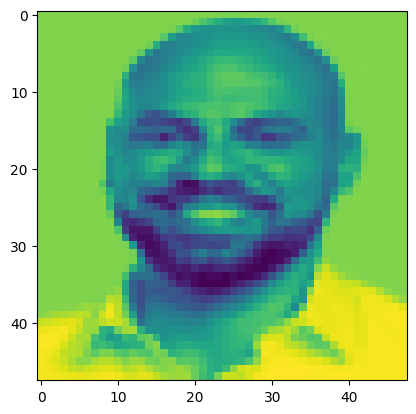

In [ ]:
plt.imshow(np.squeeze(my_image_gray))
plt.show()

In [8]:
probabilities

array([[0.00961808, 0.00113937, 0.02679518, 0.90215665, 0.01727325,
        0.03603948, 0.00697791]], dtype=float32)

Por fim, verificamos as probabilidades de cada emoção

In [9]:
number_to_class = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
index = np.argsort(probabilities[0,:])
print("Most likely class:", number_to_class[index[6]], "-- Probability:", probabilities[0,index[6]])
print("Second most likely class:", number_to_class[index[5]], "-- Probability:", probabilities[0,index[5]])
print("Third most likely class:", number_to_class[index[4]], "-- Probability:", probabilities[0,index[4]])
print("Fourth most likely class:", number_to_class[index[3]], "-- Probability:", probabilities[0,index[3]])
print("Fifth most likely class:", number_to_class[index[2]], "-- Probability:", probabilities[0,index[2]])

Most likely class: happy -- Probability: 0.90215665
Second most likely class: sad -- Probability: 0.036039475
Third most likely class: fear -- Probability: 0.026795182
Fourth most likely class: neutral -- Probability: 0.017273253
Fifth most likely class: angry -- Probability: 0.009618081
